# Quality Prediction in a Mining Process

The main goal is to use this data to predict how much impurity is in the ore concentrate. As this impurity is measured every hour, if we can predict how much silica (impurity) is in the ore concentrate, we can help the engineers, giving them early information to take actions (empowering!). Hence, they will be able to take corrective actions in advance (reduce impurity, if it is the case) and also help the environment (reducing the amount of ore that goes to tailings as you reduce silica in the ore concentrate).

## Loading the data from _Weight and Biases_ and importing python packages

In [34]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
run = wandb.init(project="ihm", group="eda", save_code=True)
local_path = wandb.use_artifact("MiningProcess_Flotation_Plant_Database.csv:latest").file()
df = pd.read_csv(local_path, decimal=",",parse_dates=["date"], index_col="date")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737453 entries, 2017-03-10 01:00:00 to 2017-09-09 23:00:00
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   % Iron Feed                   737453 non-null  float64
 1   % Silica Feed                 737453 non-null  float64
 2   Starch Flow                   737453 non-null  float64
 3   Amina Flow                    737453 non-null  float64
 4   Ore Pulp Flow                 737453 non-null  float64
 5   Ore Pulp pH                   737453 non-null  float64
 6   Ore Pulp Density              737453 non-null  float64
 7   Flotation Column 01 Air Flow  737453 non-null  float64
 8   Flotation Column 02 Air Flow  737453 non-null  float64
 9   Flotation Column 03 Air Flow  737453 non-null  float64
 10  Flotation Column 04 Air Flow  737453 non-null  float64
 11  Flotation Column 05 Air Flow  737453 non-null  float64
 12  Flotation 

In [32]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


In [35]:
dataset = deepcopy(df)

## Exploring the data

The following cells in this notebook aims to explore the data to find issues, not insights.

In [7]:
total_missing = df.isnull().sum()
missing_percent = (df.isnull().sum()/df.isnull().count())
data_missing = pd.concat([total_missing, missing_percent], axis=1, keys=['Total Missing', 'Missing Percent'])
data_missing

,Total Missing,Missing Percent
% Iron Feed,0,0.0
% Silica Feed,0,0.0
Starch Flow,0,0.0
Amina Flow,0,0.0
Ore Pulp Flow,0,0.0
Ore Pulp pH,0,0.0
Ore Pulp Density,0,0.0
Flotation Column 01 Air Flow,0,0.0
Flotation Column 02 Air Flow,0,0.0
Flotation Column 03 Air Flow,0,0.0


Assuming that the dataset might have some issue in the index (temporal discontinuity), we may check if the index is consistent:

In [17]:
hourly_indexes = pd.date_range(start=pd.to_datetime(df.index.min()), end=pd.to_datetime(df.index.max()), freq='H')
mask = hourly_indexes.isin(df.index.values)
issued_time = hourly_indexes[~mask]
issued_time

DatetimeIndex(['2017-03-16 06:00:00', '2017-03-16 07:00:00',
               '2017-03-16 08:00:00', '2017-03-16 09:00:00',
               '2017-03-16 10:00:00', '2017-03-16 11:00:00',
               '2017-03-16 12:00:00', '2017-03-16 13:00:00',
               '2017-03-16 14:00:00', '2017-03-16 15:00:00',
               ...
               '2017-03-29 02:00:00', '2017-03-29 03:00:00',
               '2017-03-29 04:00:00', '2017-03-29 05:00:00',
               '2017-03-29 06:00:00', '2017-03-29 07:00:00',
               '2017-03-29 08:00:00', '2017-03-29 09:00:00',
               '2017-03-29 10:00:00', '2017-03-29 11:00:00'],
              dtype='datetime64[ns]', length=318, freq='H')

In [31]:
lost_issued_time = 100 - (len(issued_time) / len(df) * 1e2)
print(f'If we remove the index with issue, we lose {100-lost_issued_time:.2f} % of data, which is irrelevant. Therefore, we will only consiser dates after {issued_time.max()}')

If we remove the index with issue, we lose 0.04 % of data, which is irrelevant. Therefore, we will only consiser dates after 2017-03-29 11:00:00


In [51]:
df = df.loc["2017-04-01":]
df.head(2)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-04-01,59.72,9.22,2195.31,523.283,395.785,9.45255,1.71765,176.379742,184.619458,184.292819,...,249.082,807.178,799.417,799.614,461.455,476.486,421.792,449.983,64.03,3.11
2017-04-01,59.72,9.22,2148.28,520.983,397.219,9.45499,1.71748,176.379320,184.622049,184.295736,...,250.292,810.002,791.179,800.324,471.731,472.107,460.954,453.981,64.03,3.11


In [50]:
df.index.min().month_name(), df.index.max().month_name()

('April', 'September')

When we slice the dataset to consider from april to september, we have to understand the date frequency:

    1. Do we have one data point per minute or per second?
    2. Is that consistent throght the entire dataset?

In [56]:
df.groupby(df.index.floor('H')).size().reset_index(name='count')

,date,count
0,2017-04-01 00:00:00,180
1,2017-04-01 01:00:00,180
2,2017-04-01 02:00:00,180
3,2017-04-01 03:00:00,180
4,2017-04-01 04:00:00,180
...,...,...
3883,2017-09-09 19:00:00,180
3884,2017-09-09 20:00:00,180
3885,2017-09-09 21:00:00,180
3886,2017-09-09 22:00:00,180


On every hour, we do have 180 data points, which lead us to one data point every 20 seconds

In [60]:
seconds_per_minute = 60
minutes_per_hour   = 60
data_points_minute = int(180/minutes_per_hour)
secods_per_datapoint = int(seconds_per_minute/data_points_minute)

print(f'Each data point at every {secods_per_datapoint} seconds.')

Each data point at every 20 seconds.


We are now going to understand if any day in the database has a different size:

In [72]:
df.groupby(df.index.floor('H')).size().reset_index(name='count').query("count!=180")

,date,count
216,2017-04-10,179


In [92]:
print(f"Considering 180 as a reference, the date {str(pd.to_datetime(df.groupby(df.index.floor('H')).size().reset_index(name='count').query('count!=180')['date'].values[0]))} is not consistent and we should fix it")

Considering 180 as a reference, the date 2017-04-10 00:00:00 is not consistent and we should fix it


In [103]:
df.loc['2017-04-10'].groupby(df.loc['2017-04-10'].index).count().head(3)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-04-10 00:00:00,179,179,179,179,179,179,179,179,179,179,...,179,179,179,179,179,179,179,179,179,179
2017-04-10 01:00:00,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
2017-04-10 02:00:00,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180


In [129]:
new_val = df.loc['2017-04-10 00:00:00'].values[-1]
append_val = pd.DataFrame(new_val.reshape(1,-1), columns=df.columns.tolist())
append_val['date'] = '2017-04-10 00:00:00'
append_val['date'] = pd.to_datetime(append_val['date'])
append_val = append_val.set_index('date', drop=True)
append_val

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-04-10,56.39,13.53,2357.77,392.882,397.469,10.0277,1.74996,249.478,246.096,250.729,...,252.112,600.524,598.4,600.472,446.251,446.752,426.866,432.153,65.85,1.4


In [130]:
df = pd.concat([df, append_val]).reset_index().set_index('date', drop=True)
df.loc['2017-04-10'].groupby(df.loc['2017-04-10'].index).count().head(3)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-04-10 00:00:00,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
2017-04-10 01:00:00,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
2017-04-10 02:00:00,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180


In [132]:
df.groupby(df.index.floor('H')).size().reset_index(name='count').query("count!=180")

,date,count


Now, the dataset is ready to be analysed!

In [134]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-04-01,59.72,9.22,2195.31,523.283,395.785,9.45255,1.71765,176.379742,184.619458,184.292819,...,249.082,807.178,799.417,799.614,461.455,476.486,421.792,449.983,64.03,3.11
2017-04-01,59.72,9.22,2148.28,520.983,397.219,9.45499,1.71748,176.379320,184.622049,184.295736,...,250.292,810.002,791.179,800.324,471.731,472.107,460.954,453.981,64.03,3.11
2017-04-01,59.72,9.22,2101.25,523.682,398.730,9.45742,1.71731,176.378897,184.624641,184.298653,...,248.511,800.781,802.031,802.312,474.609,469.266,493.972,447.476,64.03,3.11
2017-04-01,59.72,9.22,2054.22,524.413,400.369,9.45985,1.71713,176.378475,184.627232,184.301570,...,248.160,796.182,798.411,796.923,457.443,462.444,481.218,452.986,64.03,3.11
2017-04-01,59.72,9.22,2043.43,525.272,402.293,9.46229,1.71696,176.378052,184.629823,184.304487,...,247.747,790.783,794.159,790.596,437.286,454.435,466.243,459.457,64.03,3.11


In [172]:
sanity_df = df.resample('H').agg({'% Silica Concentrate':'nunique', '% Iron Concentrate':'nunique'})
sanity_df[sanity_df['% Silica Concentrate'].gt(1)]

,% Silica Concentrate,% Iron Concentrate
date,,
2017-04-02 08:00:00,180,180
2017-04-02 09:00:00,180,180
2017-04-03 01:00:00,180,1
2017-04-03 02:00:00,180,1
2017-04-03 03:00:00,180,180
...,...,...
2017-09-05 21:00:00,180,180
2017-09-05 22:00:00,180,180
2017-09-05 23:00:00,180,180


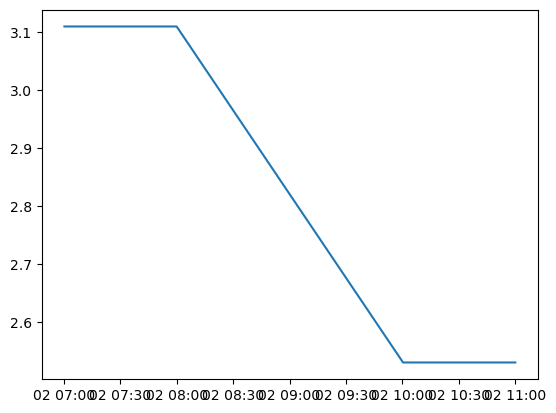

In [188]:
idx = pd.date_range(start='2017-04-02 07:00:20', end='2017-04-02 11:00:00', freq='20s')
plt.plot(idx, df.loc['2017-04-02 07:00:00':'2017-04-02 10:00:00']['% Silica Concentrate'].values)

In [5]:
run.finish()